In [1]:
from transformers import BertTokenizer, BertModel
import torch
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [37]:
#import des données pre-processés
data = pd.read_csv("20240125_dataset_pickle/data.csv", index_col=0)
X = data.titre.values
y = data.domaine.values
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)
train = data.train.values
train_index = np.array(range(len(X)))[train]
test_index = np.array(range(len(X)))[train==False]

## Embedding

In [4]:
# Chargement du tokenizer et du modèle pré-entraîné BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Encodage des séquences
encoded_sequences = []
for seq in X:
    # Tokenisation
    tokens = tokenizer.tokenize(seq)
    # Ajout des tokens [CLS] et [SEP]
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    # Convertir les tokens en identifiants d'index
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    # Convertir en tenseur pyTorch
    input_ids = torch.tensor(input_ids).unsqueeze(0)  # unsqueeze(0) pour ajouter une dimension de batch

    # Passer les données par le modèle BERT
    with torch.no_grad():
        outputs = model(input_ids)

    # Obtenir les embeddings de la couche cachée
    hidden_states = outputs[0]  # récupérer les embeddings de la couche cachée
    # Prendre la sortie de la première position ([CLS]) pour résumer la séquence
    cls_embedding = hidden_states[:, 0, :]  # [batch_size, 1, hidden_size] -> [batch_size, hidden_size]

    # Ajouter l'embedding de la séquence encodée à la liste
    encoded_sequences.append(cls_embedding)

# Concaténer les embeddings en un seul tensor
encoded_sequences = torch.cat(encoded_sequences, dim=0)

# Affichage des embeddings des séquences
print("Embeddings des séquences:")
print(encoded_sequences)


Embeddings des séquences:
tensor([[-0.9930,  0.2918, -0.6457,  ..., -0.0209,  0.0485,  0.4386],
        [-0.9212,  0.2401, -0.1814,  ...,  0.1859,  0.5711,  0.5075],
        [-0.9124, -0.0481, -0.3871,  ..., -0.2361,  0.2590,  0.5286],
        ...,
        [-0.7522, -0.1142, -0.2407,  ..., -0.3365,  0.1552,  0.4178],
        [-1.0470,  0.4469, -0.6911,  ..., -0.2363,  0.0871,  0.4320],
        [-1.0432,  0.1565,  0.1350,  ..., -0.2964, -0.0581,  0.7843]])


## Moteur de recherche

In [5]:
# moteur de recherche

entree = "La riziculture et la maîtrise de l'eau"
tokens = tokenizer.tokenize(entree)
# Ajout des tokens [CLS] et [SEP]
tokens = ['[CLS]'] + tokens + ['[SEP]']
# Convertir les tokens en identifiants d'index
input_ids = tokenizer.convert_tokens_to_ids(tokens)
# Convertir en tenseur pyTorch
input_ids = torch.tensor(input_ids).unsqueeze(0)  # unsqueeze(0) pour ajouter une dimension de batch

# Passer les données par le modèle BERT
with torch.no_grad():
    outputs = model(input_ids)

# Obtenir les embeddings de la couche cachée
hidden_states = outputs[0]  # récupérer les embeddings de la couche cachée
# Prendre la sortie de la première position ([CLS]) pour résumer la séquence
cls_embedding = hidden_states[:, 0, :]  # [batch_size, 1, hidden_size] -> [batch_size, hidden_size]


In [6]:
# Résultat de la recherche
X[np.argsort(torch.sum((cls_embedding - encoded_sequences)**2, axis=1))[0:5]]

array(["L'avènement de la moralité et le rapport à la nature",
       "La crise des matières premières et les mesures internes d'organisation",
       "L'ajustement contre l'industrie",
       "La riziculture et la maîtrise de l'eau dans le Kampuchea démocratique",
       "L'équipement technique des campagnes"], dtype=object)

## Classification

In [7]:
import networkx as nx
# Import du graphe
G= nx.read_gexf("20240125_dataset_pickle/auteur.gexf")

In [43]:
y_is_edged = []
for edge in G.edges:
    for node in edge:
        y_is_edged.append(data.domaine[node])
unique_values, counts = np.unique(y_is_edged, return_counts=True)

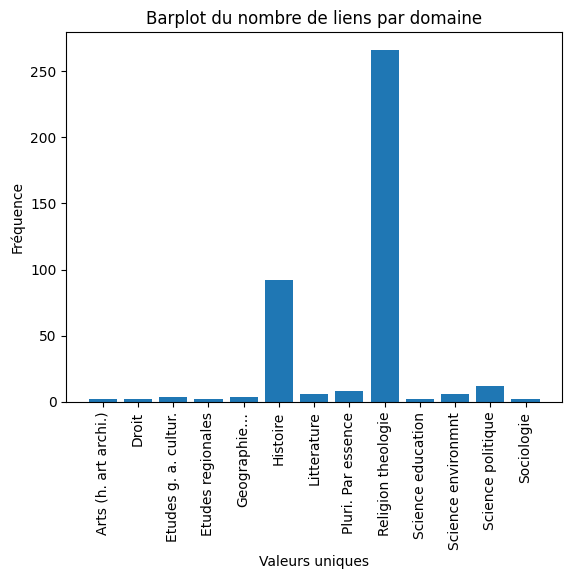

In [47]:
# Créer le barplot
plt.bar(unique_values, counts)

# Ajouter des étiquettes aux axes
plt.xlabel('Valeurs uniques')
plt.ylabel('Fréquence')
plt.title('Barplot du nombre de liens par domaine')


# Faire pivoter les labels sur l'axe des abscisses
plt.xticks(rotation=90)

# Afficher le plot
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from sklearn.metrics import accuracy_score

# Définition du modèle GCN
class GCNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Supposons que 'encoded_sequences' soit votre tensor contenant les embeddings BERT
# Supposons également que 'adjacency_matrix' soit la matrice d'adjacence de votre graphe

# Création des données du graphe
x = encoded_sequences  # Les embeddings BERT

# Obtenez les nœuds et les arêtes du graphe
nodes = list(G.nodes())
edges = list(G.edges())

# Créez une liste de tuples pour représenter les indices des arêtes
edge_index_list = [(nodes.index(edge[0]), nodes.index(edge[1])) for edge in edges]

# Convertissez la liste de tuples en un tensor PyTorch
edge_index = torch.tensor(edge_index_list).t().contiguous()

# Transférez le tensor sur GPU s'il est disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
edge_index = edge_index.to(device)

# Troncation du graphe entre données d'entrainement et de test
a,b=edge_index<400
edge_index_train = torch.tensor((list(edge_index[0][a & b]), list(edge_index[1][a & b])))
a,b=edge_index>400
edge_index_test = torch.tensor((list(edge_index[0][a & b]), list(edge_index[1][a & b]))) - 400

# Création de l'instance de modèle GCN
input_dim = x.size(1)  # Dimension d'entrée = taille des embeddings BERT
hidden_dim = 64  # Taille de la couche cachée
output_dim = len(y)  # Nombre de classes de sortie (par exemple, 2 pour une classification binaire)
model = GCNClassifier(input_dim, hidden_dim, output_dim)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Formation du modèle
num_epochs = 43
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(x[train_index,:], edge_index_train)
    # Supposons que 'labels' soit les étiquettes de classe pour chaque nœud dans le graphe
    loss = criterion(output, torch.tensor(y_int[train_index]))
    loss.backward()
    optimizer.step()

    # Évaluation sur les données de validation
    model.eval()
    with torch.no_grad():
        output = model(x[test_index,:], edge_index_test)
        _, predicted = torch.max(output, 1)  # Obtenez l'indice de la classe prédite avec la plus grande probabilité
        accuracy = accuracy_score(torch.tensor(y_int[test_index]).cpu().numpy(), predicted.cpu().numpy())  # Calculez l'accuracy
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Accuracy: {accuracy}')

Epoch 1, Loss: 6.275543689727783, Accuracy: 0.27
Epoch 2, Loss: 4.182807445526123, Accuracy: 0.27
Epoch 3, Loss: 2.675705909729004, Accuracy: 0.34
Epoch 4, Loss: 2.385348081588745, Accuracy: 0.25
Epoch 5, Loss: 2.253538131713867, Accuracy: 0.29
Epoch 6, Loss: 2.1334564685821533, Accuracy: 0.29
Epoch 7, Loss: 1.9630388021469116, Accuracy: 0.35
Epoch 8, Loss: 2.006265878677368, Accuracy: 0.36
Epoch 9, Loss: 1.9075666666030884, Accuracy: 0.39
Epoch 10, Loss: 1.815626859664917, Accuracy: 0.4
Epoch 11, Loss: 1.7444595098495483, Accuracy: 0.42
Epoch 12, Loss: 1.6954913139343262, Accuracy: 0.44
Epoch 13, Loss: 1.6565735340118408, Accuracy: 0.42
Epoch 14, Loss: 1.5802133083343506, Accuracy: 0.47
Epoch 15, Loss: 1.5046731233596802, Accuracy: 0.46
Epoch 16, Loss: 1.4617152214050293, Accuracy: 0.46
Epoch 17, Loss: 1.406765103340149, Accuracy: 0.47
Epoch 18, Loss: 1.3769372701644897, Accuracy: 0.51
Epoch 19, Loss: 1.3198981285095215, Accuracy: 0.52
Epoch 20, Loss: 1.2587099075317383, Accuracy: 0.5

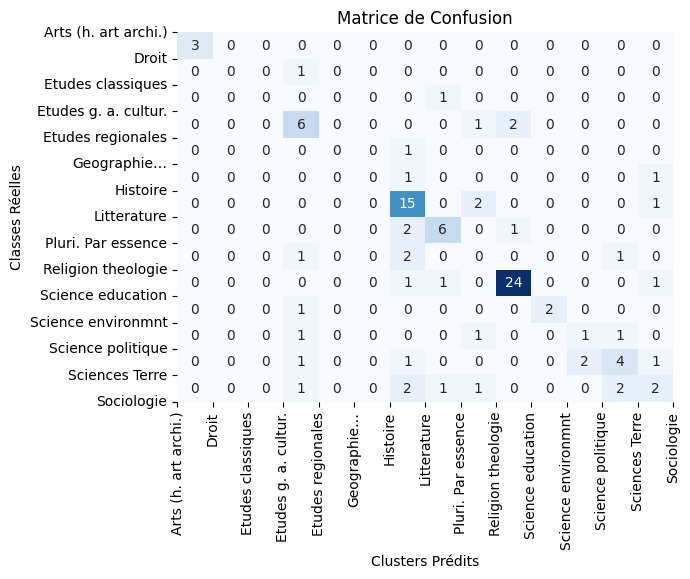

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(torch.tensor(y_int[test_index]).cpu().numpy(), predicted.cpu().numpy()), annot=True, fmt='d', cmap='Blues', cbar=False)
# Ajouter les vrais labels sur l'axe y
plt.yticks(ticks=np.arange(len(set(y))), labels=sorted(set(y)), rotation=0)
plt.xticks(ticks=np.arange(len(set(y))), labels=sorted(set(y)), rotation=90)

plt.xlabel('Clusters Prédits')
plt.ylabel('Classes Réelles')
plt.title('Matrice de Confusion')
plt.show()

## Clustering

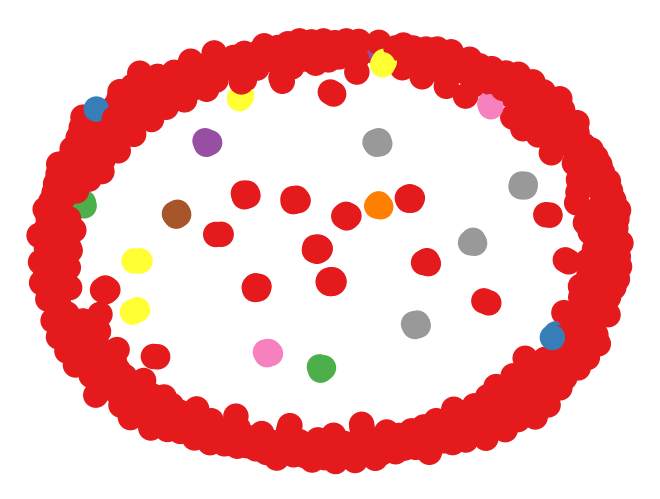

In [12]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# Obtenir la matrice d'adjacence du graphe
adjacency_matrix = nx.adjacency_matrix(G)

# Convertir la matrice d'adjacence en un tableau NumPy
adjacency_matrix = adjacency_matrix.toarray()


# Effectuer le clustering spectral
n_clusters = len(np.unique(y))  # Nombre de clusters à trouver
spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=0)
clusters = spectral.fit_predict(adjacency_matrix)

# Afficher le graphe avec les clusters colorés
pos = nx.spring_layout(G)  # Positionnement des nœuds
nx.draw(G, pos, node_color=clusters, cmap=plt.cm.Set1, with_labels=False, arrowsize = 100)
plt.show()

0.27404408817635273


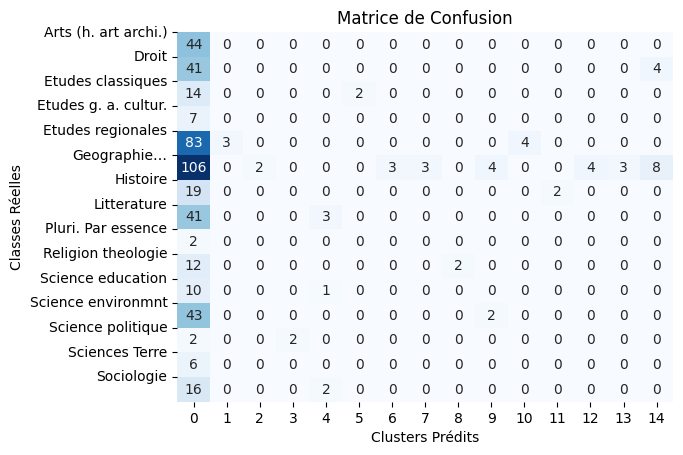

In [18]:
from sklearn.metrics import rand_score
print(rand_score(y, clusters))

class_mapping = {label: idx for idx, label in enumerate(set(y))}
y_mapped = [class_mapping[label] for label in y]
sns.heatmap(confusion_matrix(y_mapped, clusters), annot=True, fmt='d', cmap='Blues', cbar=False)
# Ajouter les vrais labels sur l'axe y
plt.yticks(ticks=np.arange(len(set(y))), labels=sorted(set(y)), rotation=0)

plt.xlabel('Clusters Prédits')
plt.ylabel('Classes Réelles')
plt.title('Matrice de Confusion')
plt.show()